# Mobile phone data tutorial

# Mobile phone data tutorial

In this short tutorial, we will explore how we can work with a mobile phone data set to understand the dynamics of our cities. The data set contains mobile phone data for the city of Milan, Italy, for a two month period in November and December 2013. The data set contains information on the number of SMSs sent and received, phone calls made and received, and Internet usage, aggregated for different areas in Milan and in ten minute intervals. For instance, the data set can tell us how many SMSs were sent in the ten minute interval starting at 8am on 2nd November 2013 for a 100m x 100x area in Milan (note: technically the data does not contain the actual number of SMSs, but rather a number proportional to it for privacy reasons).

The code will download the data set for a 7-day period (starting on 1st November 2013) automatically, so that you don't have to do that yourself. However, the full data set for the two month period is publicly available for download at the following links:

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EGZHFV

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/QJWLFU

There is also a paper that provides details about the data set used here, as well as other publicly available data sets that you may find interesting:

https://www.nature.com/articles/sdata201555

The tutorial will show you how to:

* load the mobile phone data into this Jupyter Notebook using Python
* create a map of the area of Milan for which the data is available
* create plots of the mobile phone data for different locations

I suggest you first have a look at the tutorial and see if you can understand how it works (you won't need to understand all the details of the code!). Then, you can go on Google Maps and find a location in Milan for which you would like to plot the data, and follow the instructions below to see if you can do that!

### Import required libraries

This section simply loads the libraries which are used in this tutorial. Libraries contain a number of functions that other people have written and made available to use for specific tasks. If you've never used Python before, Pandas is a particularly useful library which is very popular in data analysis.

In [48]:
import pandas as pd
import geopandas as gpd
import contextily as cx
from datetime import datetime
import os

### Define a function used in this notebook

This function will be used later in the notebook to help you plot the data for your chosen location in Milan (shh, you don't actually need to understand how this function works if you don't want to!).

In [2]:
def find_cell_id(coords, grid):
    """
    Function to find the cell id within which a point falls.

    Parameters:
    coords (geopandas.GeoDataFrame): The GeoDataFrame containing the point chosen.
    grid (geopandas.GeoDataFrame): The GeoDataFrame containing the grid.

    Returns:
    str or None: The ID of the cell containing the point, or None if the point is not within any polygon.
    """
    # Ensure crs of two geodataframes match
    coords.to_crs(crs = grid.crs, inplace = True)
    
    # Perform a spatial join between the point GeoDataFrame and the polygon GeoDataFrame
    temp_gdf = gpd.sjoin(coords, grid, how="left", predicate="within")
    
    # Extract the label of the polygon containing the point, if any
    if not temp_gdf.empty:
        return temp_gdf.iloc[0]['cellId']
    else:
        return None

### Read data files

You are now ready to read the data files and put them all together in one big table (in the Pandas language, a data frame!).

In [24]:
# Create list of urls for the data files
data_files = ['https://github.com/FedericoBotta/mobility/releases/download/v1/sms-call-internet-mi-2013-11-0' + str(x) + '.txt' for x in range(1, 8)]

# Define the column names
column_names = ['Square_id', 'Timestamp', 'Country_code', 'SMS-in', 'SMS-out', 'Call-in', 'Call-out', 'Internet']

# Initialize an empty list to store individual DataFrames
dataframes = []

# Loop through each file and read it into a DataFrame with specified column names
for file in data_files:
    # Read the file and specify the column names
    df = pd.read_csv(file, names=column_names, sep = '\t')  
    dataframes.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
mobile_df = pd.concat(dataframes, ignore_index=True)
mobile_df['Timestamp'] = mobile_df['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x/1000))

# Read the file containing the geographical data
milano_grid = gpd.read_file('https://github.com/FedericoBotta/mobility/releases/download/v1/milano-grid.geojson')
milano_grid.to_crs(epsg=3857, inplace = True)

### Explore the data

First let's have a look at a map of the area for which data is available. You will see a map of Milan, and on top of that you will see the grid for which the mobile data is available. Each small cell in the grid is 100m x 100m, and the mobile phone data is aggregated in these small cells.

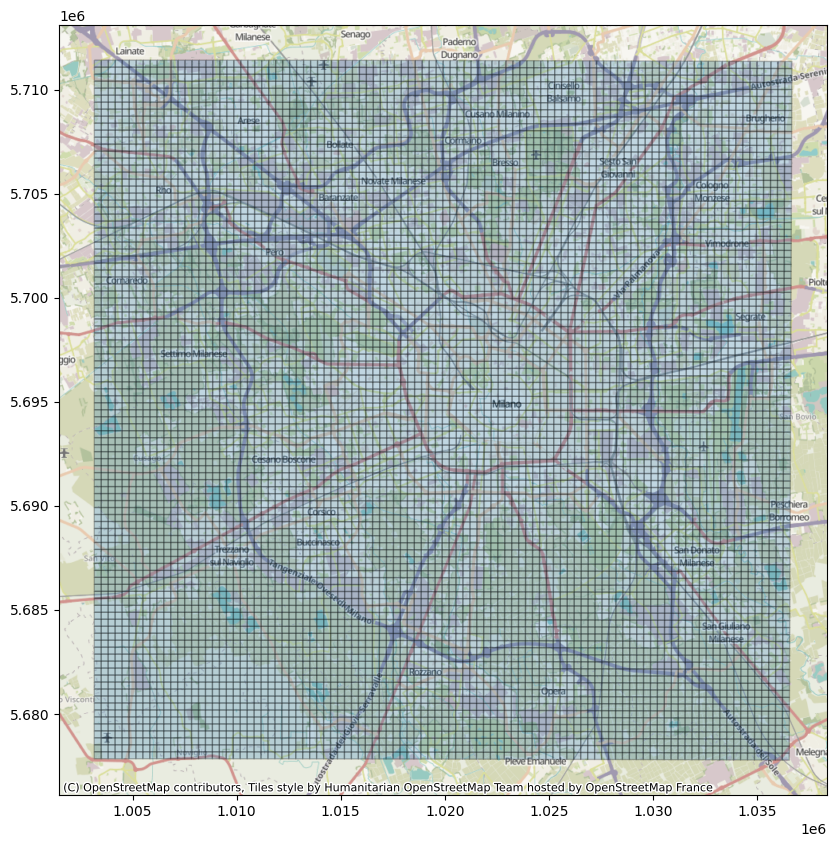

In [16]:
ax = milano_grid.plot(figsize = (10,10), alpha = 0.25, edgecolor = 'black')
cx.add_basemap(ax)

Next, we will explore how mobile phone activity varies across different locations in the city of Milan.

You can select the area of the city for which you want to plot the data by finding a location on Google Maps: https://maps.app.goo.gl/uzYAdd6PNEXNYbWF6

Find a location that you think may be intereting (think tourist attractions, shops, restaurants, train stations, or even residential areas) and right click on it. This should open a menu similar to the one in the screenshot below. If you click on the coordinates that appear (the numbers in the first row of the menu, 45.46436, 9.19022 in this case), this will automatically copy them for you. You should then past them in the line in the next part of the code (see comment for instructions on where to put them!).

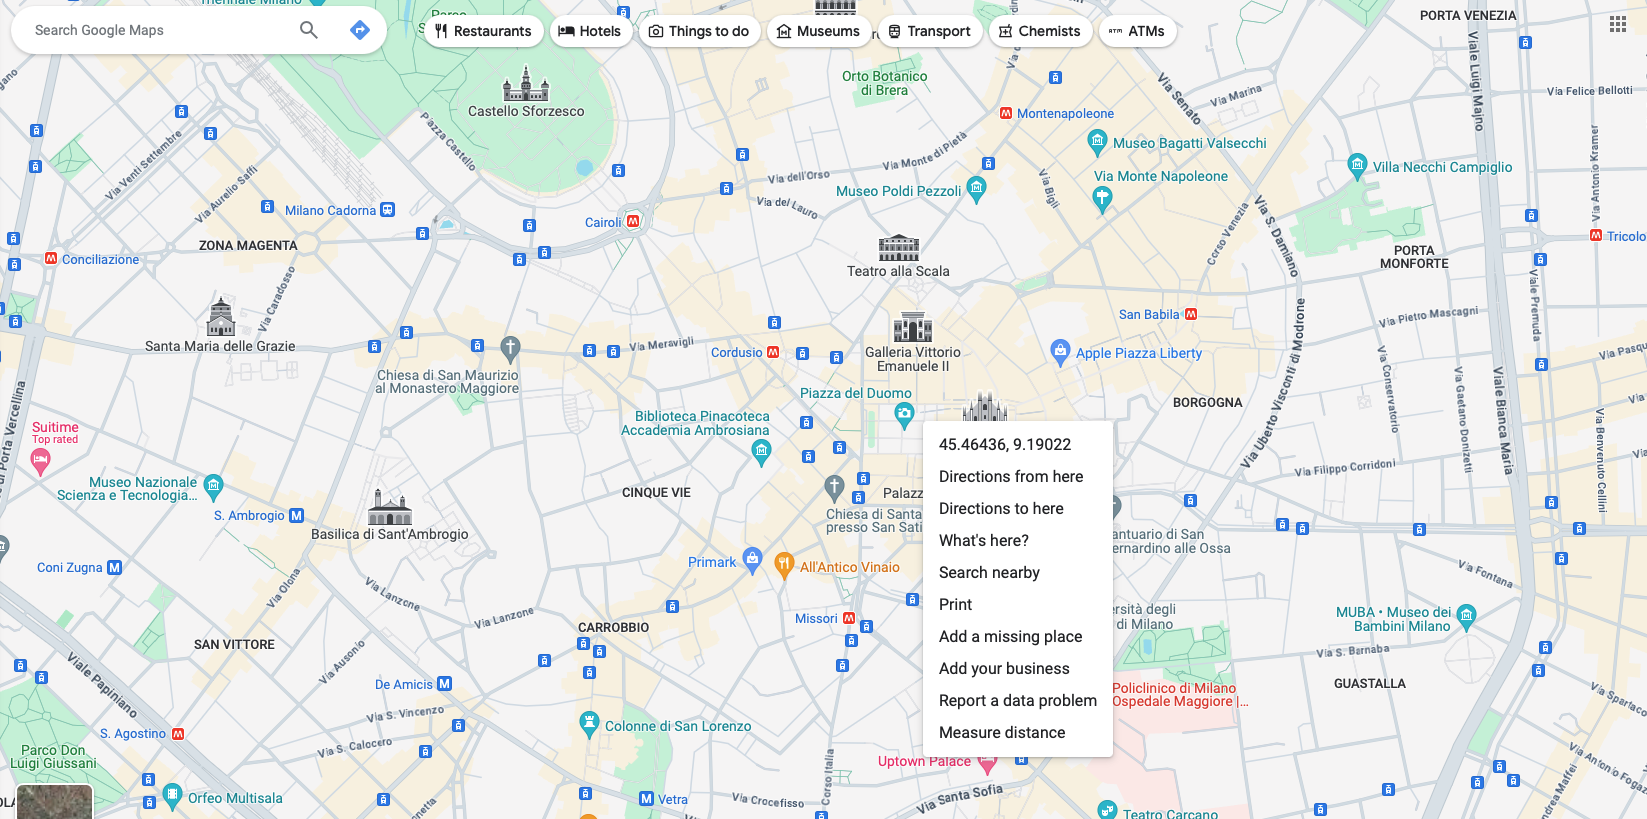

<Axes: xlabel='Timestamp'>

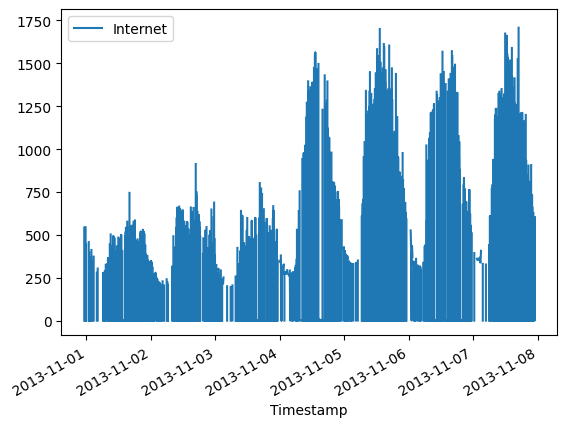

In [28]:
# Then let's plot the time series of the data for an individual cell in the study area


# In the next part of the code, please replace the two numbers with the coordinates of the location you have chosen.
# If you copied them from Google Maps, they will be in the correct format already.
# If not, make sure the two numbers are separatedy by a comma, and that the largest one is first (this is the latitude of the location).
[lat, long] = [45.4683364819956, 9.174417943674701]
point_df = pd.DataFrame({'Long': [long], 'Lat': [lat]})

point_gdf = gpd.GeoDataFrame(point_df, geometry=gpd.points_from_xy(point_df.Long, point_df.Lat, crs="EPSG:4326"))

#let's find the specific cell in our data set which contains the location you have selected.
cell_id = find_cell_id(point_gdf,milano_grid)

cell_df = mobile_df[mobile_df['Square_id'] == cell_id]
#the next row generates a plot of the mobile phone data for the location you have picked.
#in the y variable, you can use the following options: 'SMS-in', 'SMS-out', 'Call-in', 'Call-out', 'Internet'
#each of them will plot a different variable in the data set.
#Explore which ones you think are more interesting!
cell_df.plot(x = 'Timestamp', y = 'Internet')

<Axes: xlabel='Timestamp'>

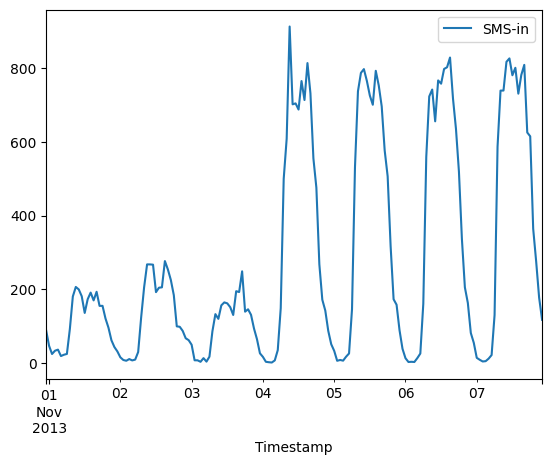

In [47]:
# We can make the data a bit less noisy and make any pattern more obvious by aggregating the original data.
# Here we aggregate it to hourly (the '1h' option in the resample function), but feel free to explore other aggregation levels!

temp_df = cell_df.set_index('Timestamp')
hourly = temp_df.resample('1h').sum()
hourly.drop(['Square_id', 'Country_code'],inplace = True, axis = 1)
hourly.reset_index(inplace = True)
#As before, you can change the y variable using any of the following options: 'SMS-in', 'SMS-out', 'Call-in', 'Call-out', 'Internet'
hourly.plot(x = 'Timestamp', y = 'SMS-in')

## Installing Python on your own computer

If you have never used Python and would like to use it on your own computer, here some advice and guide to install Python using Anaconda. Anaconda provides a distribution of Python (and indeed R) that allows for installing and managing libraries more easily.

An easy documentation to install Python using Anaconda on MAC OS: https://docs.anaconda.com/free/anaconda/install/mac-os/

Documentation to install Python using anaconda on Windows: https://docs.anaconda.com/free/anaconda/install/windows/

Once you open Anaconda, you should be able to find the Jupyter Notebook with an "Install" button that you can click (see below):

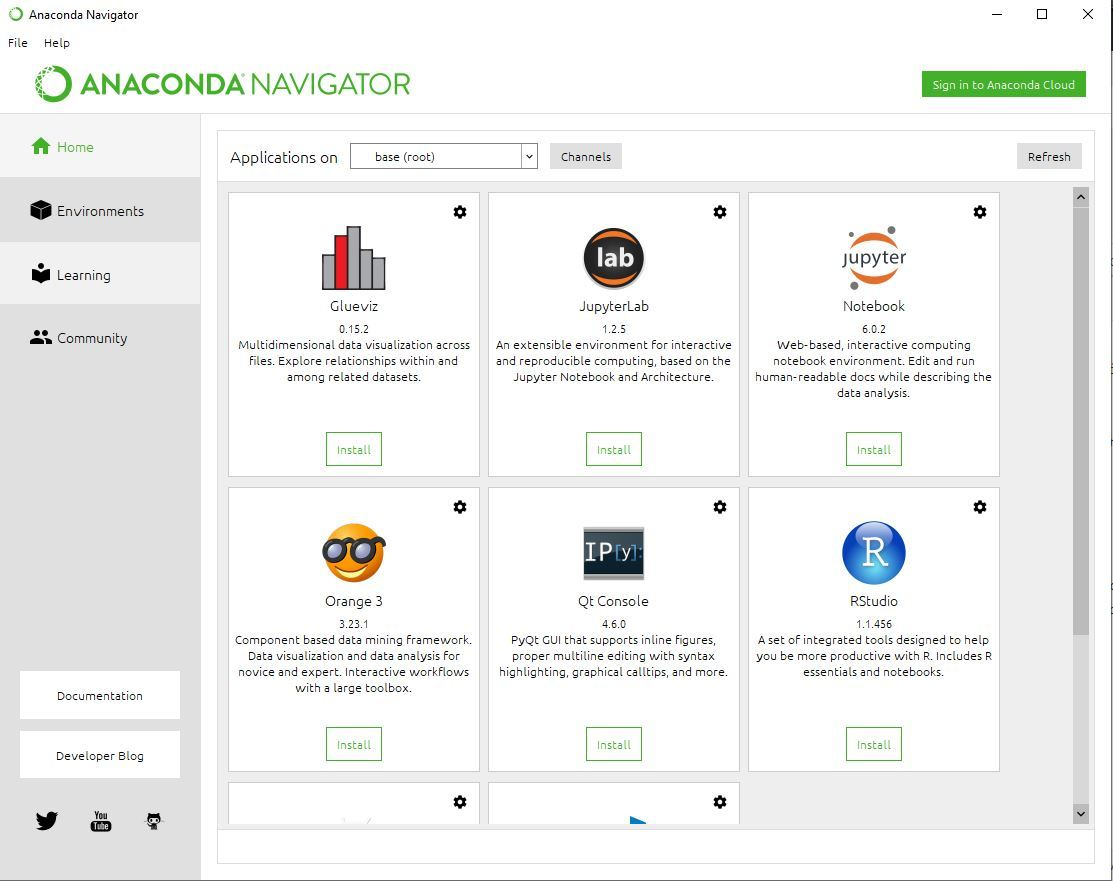